In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_zip_path = '/content/drive/MyDrive/tomato_dataset/train.zip'
val_zip_path = '/content/drive/MyDrive/tomato_dataset/val.zip'

In [ ]:
import zipfile

# Extract train.zip
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Extract val.zip
with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/val')

In [ ]:
import os

print("Train folders:", os.listdir('/content/train'))
print("Validation folders:", os.listdir('/content/val'))

Train folders: ['train']
Validation folders: ['val']


In [ ]:
training = "/content/train/train"
testing = "/content/val/val"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  testing,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 1000 files belonging to 10 classes.
Using 800 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  training,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 10000 files belonging to 10 classes.
Using 2000 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
trian_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9519985


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(0.1 / 256)
])

In [ ]:
data_augmentation  = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

In [ ]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x, training=True),y),
).prefetch(buffer_size = tf.data.AUTOTUNE)

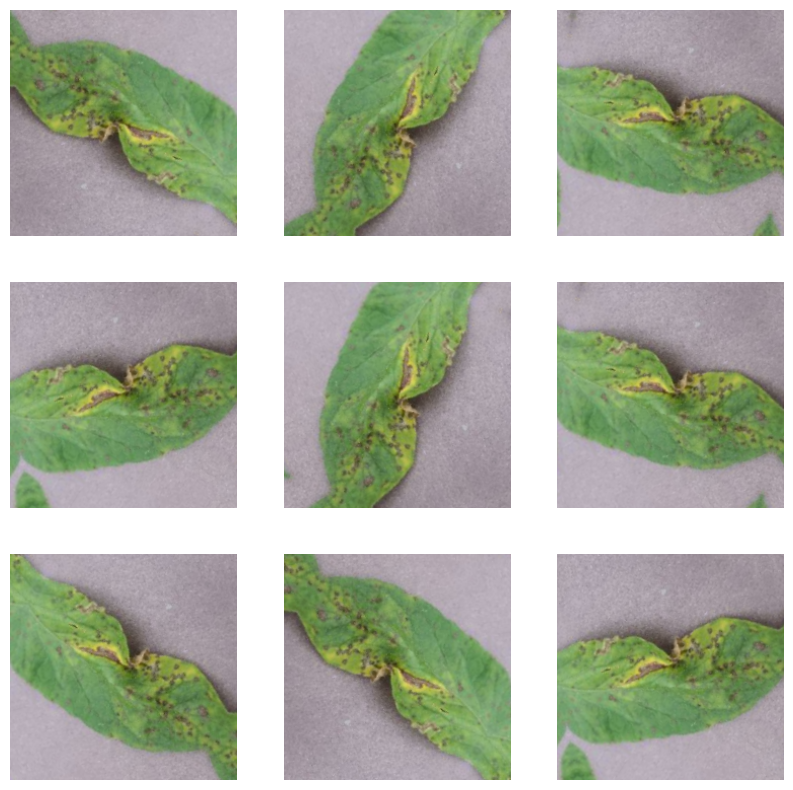

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

model CNN

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss= "sparse_categorical_crossentropy",
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,310,122 (12.63 MB)

 Trainable params: 3,310,122 (12.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  epochs=epochs,
  validation_data=val_ds,
  batch_size=BATCH_SIZE
)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 88s 328ms/step - accuracy: 0.3546 - loss: 1.7569 - val_accuracy: 0.5520 - val_loss: 1.3802
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 289ms/step - accuracy: 0.7422 - loss: 0.7466 - val_accuracy: 0.6720 - val_loss: 1.0162
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 306ms/step - accuracy: 0.7936 - loss: 0.5839 - val_accuracy: 0.5710 - val_loss: 1.6750
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 288ms/step - accuracy: 0.8263 - loss: 0.4731 - val_accuracy: 0.7070 - val_loss: 0.9497
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.8672 - loss: 0.3797 - val_accuracy: 0.5125 - val_loss: 2.7105
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 72s 286ms/step - accuracy: 0.8592 - loss: 0.4064 - val_accuracy: 0.6425 - val_loss: 1.2160
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.8846 - loss: 0.3239 - val_accuracy: 0.7245 - val_loss: 0.9999
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 281ms/step - accuracy: 0.8959 - loss: 

In [ ]:
model.evaluate(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8688 - loss: 0.5366


[0.4877098798751831, 0.8712499737739563]

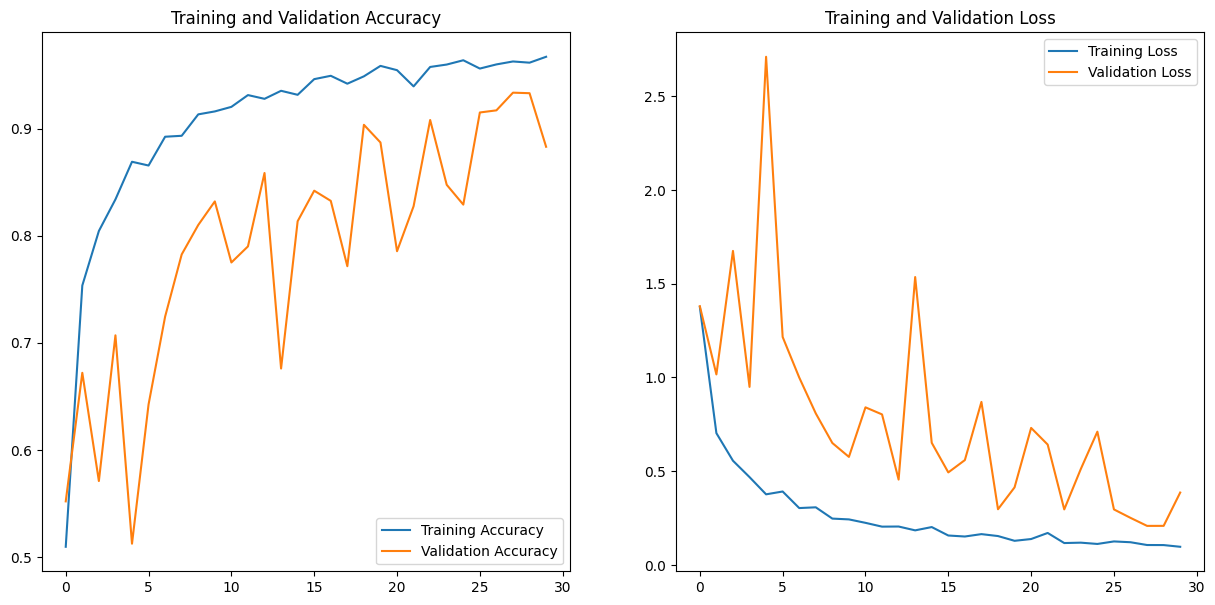

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/Model_CNN_final.keras')

In [ ]:
import os
os.path.exists('/content/Model_CNN_final.keras')

True

In [ ]:
from google.colab import files
files.download('/content/Model_CNN_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Efficient Net model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

In [ ]:
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [ ]:
from keras._tf_keras.keras.applications.efficientnet_v2 import EfficientNetV2B0
base_model = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
num_classes = 10
model_eff = Sequential()
model_eff.add(base_model)  # Make sure base_model is already defined
model_eff.add(Flatten())
model_eff.add(Dense(256, activation='relu'))
model_eff.add(Dropout(0.5))
model_eff.add(BatchNormalization())
model_eff.add(Dense(num_classes, activation='softmax'))
model_eff.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,979,482 (83.85 MB)

 Trainable params: 16,059,658 (61.26 MB)

 Non-trainable params: 5,919,824 (22.58 MB)

In [ ]:
from keras._tf_keras.keras.losses import SparseCategoricalCrossentropy # Import SparseCategoricalCrossentropy
model_eff.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your goal
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)

In [ ]:
epochs = 15
history = model_eff.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=early_stopping
)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 89ms/step - accuracy: 0.6215 - loss: 1.1422 - val_accuracy: 0.9030 - val_loss: 0.3551
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.8934 - loss: 0.3600 - val_accuracy: 0.9440 - val_loss: 0.2690
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9389 - loss: 0.2243 - val_accuracy: 0.9385 - val_loss: 0.2363
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.9523 - loss: 0.1775 - val_accuracy: 0.9470 - val_loss: 0.2181
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9609 - loss: 0.1389 - val_accuracy: 0.9560 - val_loss: 0.2278
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.9613 - loss: 0.1310 - val_accuracy: 0.9550 - val_loss: 0.2463
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.9634 - loss: 0.1201 - val_accuracy: 0.9500 - val_loss: 0.3050
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


In [ ]:
model_eff.evaluate(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8918 - loss: 0.3393


[0.3096180260181427, 0.9012500047683716]

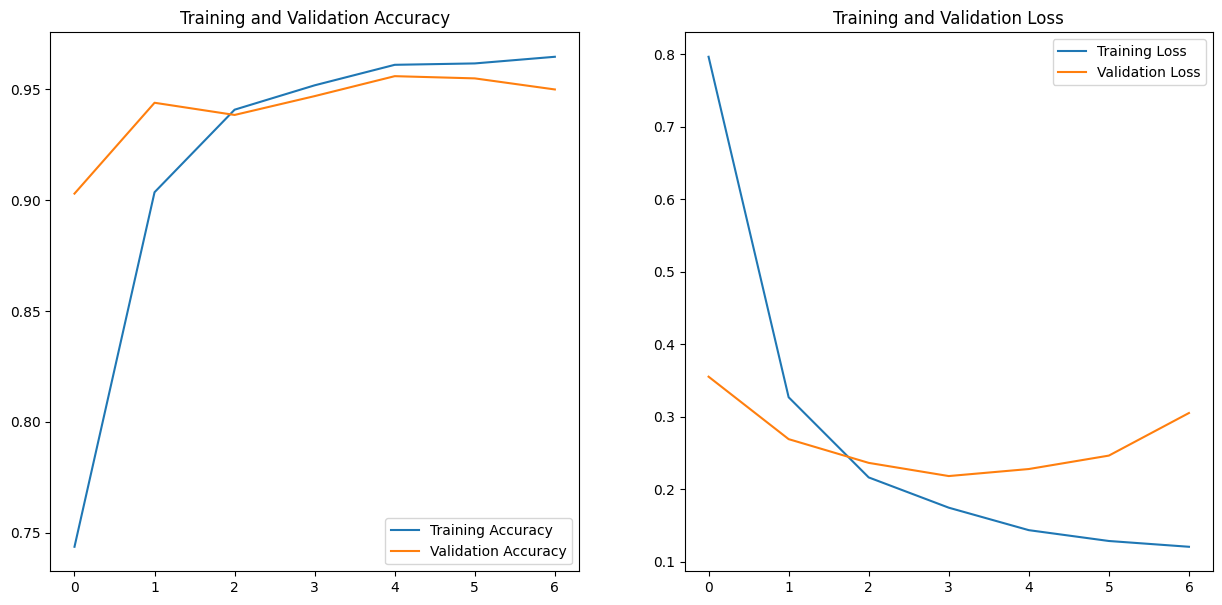

In [ ]:
num_epochs_trained = len(history.history['loss'])

# Update epochs_range to reflect the actual number of epochs
epochs_range = range(num_epochs_trained)

# Get accuracy and loss from the history object of the trained EfficientNet model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Change model.save to model_eff.save to save the correct model
model_eff.save('/content/Model_EFF_final1.keras')

In [ ]:
import os
os.path.exists('/content/Model_EFF_final1.keras')

True

In [ ]:
from google.colab import files
files.download('/content/Model_EFF_final1.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>